In [7]:
import os
import rasterio
import numpy as np

def compute_percent_change_rasters(file1, file2, output_file):
    """Compute percent change for NDVI and LST between two raster files."""
    with rasterio.open(file1) as src1, rasterio.open(file2) as src2:
        profile = src1.profile.copy()
        data1 = src1.read()
        data2 = src2.read()

        # Avoid division by zero
        ndvi1, lst1 = data1[0], data1[1]
        ndvi2, lst2 = data2[0], data2[1]

        ndvi_change = np.where(ndvi1 != 0, ((ndvi2 - ndvi1) / ndvi1) * 100, 0)
        lst_change = np.where(lst1 != 0, ((lst2 - lst1) / lst1) * 100, 0)

        result = np.stack([ndvi_change, lst_change])
        profile.update(dtype=rasterio.float32, count=2)

        with rasterio.open(output_file, 'w', **profile) as dst:
            dst.write(result.astype(rasterio.float32))

    print(f"✅ Saved percent change raster: {output_file}")

# 🔁 Sequential Year Pair Processing
def process_all_year_pairs(start_year, end_year, input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    
    for year in range(start_year, end_year):
        file1 = os.path.join(input_dir, f'NDVI_LST_{year}.tif')
        file2 = os.path.join(input_dir, f'NDVI_LST_{year + 1}.tif')
        output_file = os.path.join(output_dir, f'NDVI_LST_change_{year}_{year + 1}.tif')
        
        if os.path.exists(file1) and os.path.exists(file2):
            print(f"🔄 Computing percent change: {year} → {year + 1}")
            compute_percent_change_rasters(file1, file2, output_file)
        else:
            print(f"⚠️ Missing files for {year} or {year + 1}, skipping.")



In [8]:
#run the analysis
# Run the percent change analysis for all year pairs
process_all_year_pairs(
    start_year=2013, 
    end_year=2024,
    input_dir='../uhi-analysis/gee_exports',
    output_dir='../uhi-analysis/change-detection-results'
)


🔄 Computing percent change: 2013 → 2014
✅ Saved percent change raster: ../uhi-analysis/change-detection-results\NDVI_LST_change_2013_2014.tif
🔄 Computing percent change: 2014 → 2015


C:\Users\TR\AppData\Local\Temp\ipykernel_30772\870006994.py:16: RuntimeWarning: divide by zero encountered in divide
  ndvi_change = np.where(ndvi1 != 0, ((ndvi2 - ndvi1) / ndvi1) * 100, 0)


✅ Saved percent change raster: ../uhi-analysis/change-detection-results\NDVI_LST_change_2014_2015.tif
🔄 Computing percent change: 2015 → 2016
✅ Saved percent change raster: ../uhi-analysis/change-detection-results\NDVI_LST_change_2015_2016.tif
🔄 Computing percent change: 2016 → 2017
✅ Saved percent change raster: ../uhi-analysis/change-detection-results\NDVI_LST_change_2016_2017.tif
🔄 Computing percent change: 2017 → 2018
✅ Saved percent change raster: ../uhi-analysis/change-detection-results\NDVI_LST_change_2017_2018.tif
🔄 Computing percent change: 2018 → 2019
✅ Saved percent change raster: ../uhi-analysis/change-detection-results\NDVI_LST_change_2018_2019.tif
🔄 Computing percent change: 2019 → 2020
✅ Saved percent change raster: ../uhi-analysis/change-detection-results\NDVI_LST_change_2019_2020.tif
🔄 Computing percent change: 2020 → 2021
✅ Saved percent change raster: ../uhi-analysis/change-detection-results\NDVI_LST_change_2020_2021.tif
🔄 Computing percent change: 2021 → 2022
✅ Save

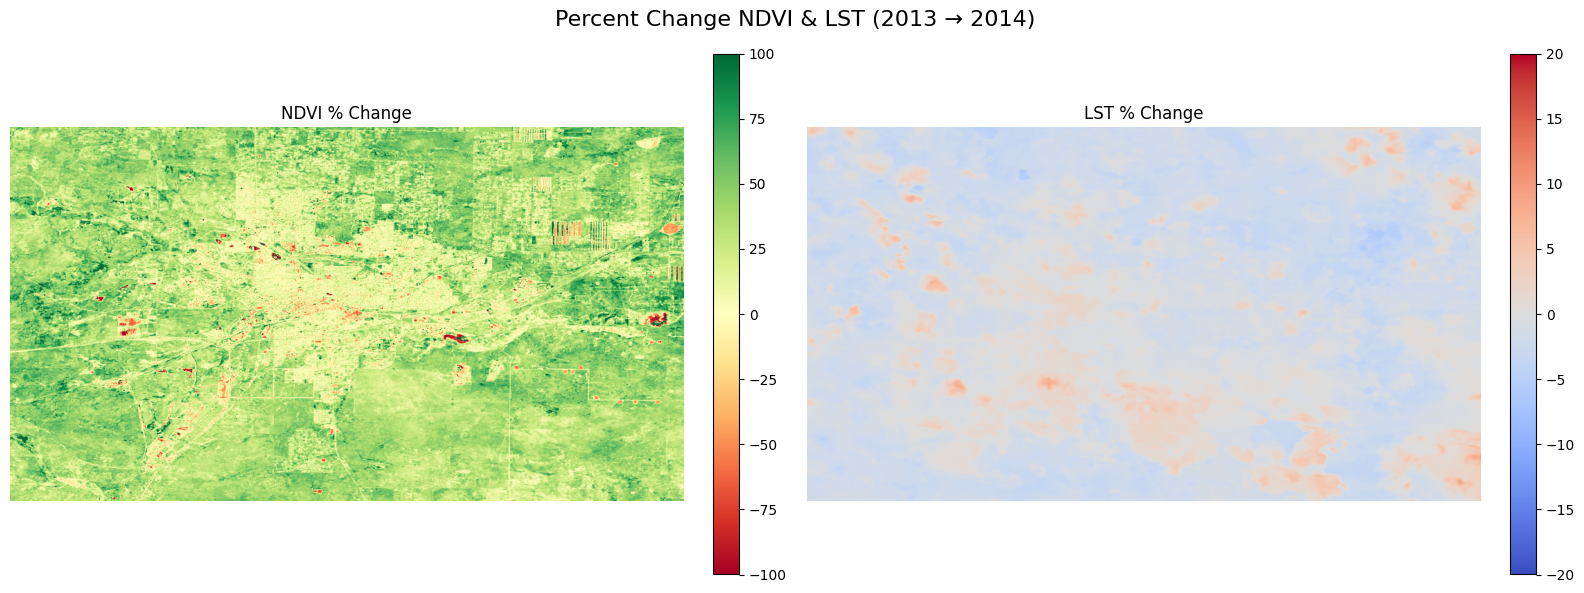

In [9]:
#heat-map

import rasterio
import matplotlib.pyplot as plt

def plot_percent_change_map(file_path, year_pair):
    with rasterio.open(file_path) as src:
        ndvi_change = src.read(1)
        lst_change = src.read(2)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        plt.suptitle(f"Percent Change NDVI & LST ({year_pair})", fontsize=16)

        ndvi_img = ax1.imshow(ndvi_change, cmap='RdYlGn', vmin=-100, vmax=100)
        ax1.set_title("NDVI % Change")
        plt.colorbar(ndvi_img, ax=ax1, fraction=0.046, pad=0.04)

        lst_img = ax2.imshow(lst_change, cmap='coolwarm', vmin=-20, vmax=20)
        ax2.set_title("LST % Change")
        plt.colorbar(lst_img, ax=ax2, fraction=0.046, pad=0.04)

        for ax in [ax1, ax2]:
            ax.axis('off')

        plt.tight_layout()
        plt.show()

# 🖼️ Example: Plot 2013–2014
plot_percent_change_map('../uhi-analysis/change-detection-results/NDVI_LST_change_2013_2014.tif', '2013 → 2014')


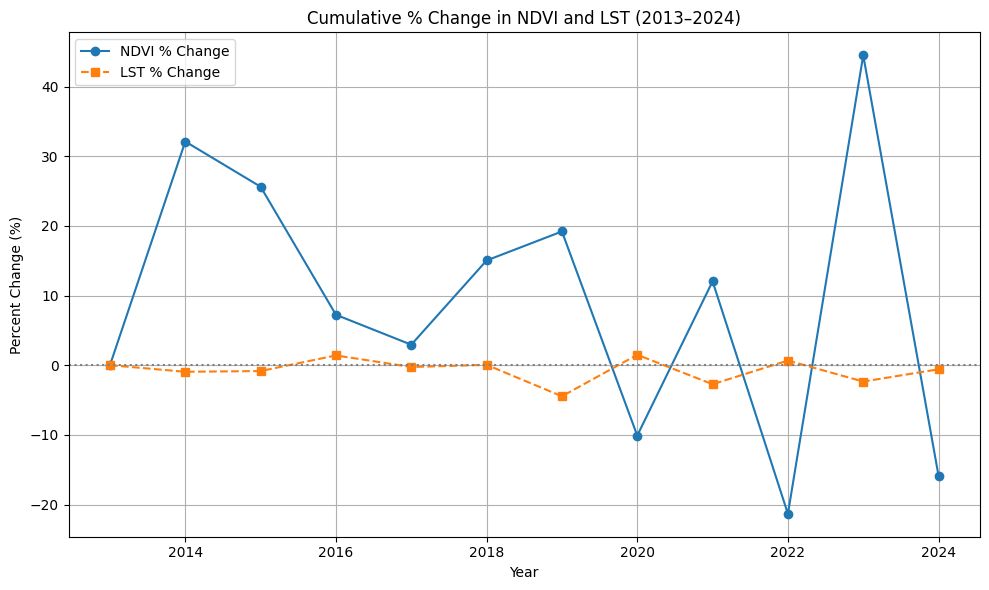

In [10]:
import pandas as pd


# Load csv
df = pd.read_csv("NDVI_LST_Timeseries.csv")

# Calculate % change relative to 2013
df['NDVI_%_Change'] = ((df['Mean_NDVI'] - df['Mean_NDVI'].iloc[0]) / df['Mean_NDVI'].iloc[0]) * 100
df['LST_%_Change'] = ((df['Mean_LST'] - df['Mean_LST'].iloc[0]) / df['Mean_LST'].iloc[0]) * 100

# Plot
plt.figure(figsize=(10, 6))
plt.plot(df['Year'], df['NDVI_%_Change'], label='NDVI % Change', marker='o')
plt.plot(df['Year'], df['LST_%_Change'], label='LST % Change', marker='s', linestyle='--')
plt.axhline(0, color='gray', linestyle='dotted')
plt.title("Cumulative % Change in NDVI and LST (2013–2024)")
plt.xlabel("Year")
plt.ylabel("Percent Change (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
